In [29]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Draw, PandasTools, MACCSkeys, rdFingerprintGenerator

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNetCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, RobustScaler

from pathlib import Path

In [2]:
pd.options.display.max_columns = 50

In [3]:
data = pd.read_csv('data_descriptors.csv', index_col=0)
data.head()

,molecule_chembl_id,Ki,units,pKi,smiles,mols,maccs,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,tpsa,qed,clogp,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,CHEMBL132806,57.0,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,<rdkit.Chem.rdchem.Mol object at 0x0000018B5EA...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,429.191323,0.260870,9,1,5,9,32,7,103.14,0.420000,3.9613,2.785385,0,0,0,1,4,5,0,0,0
1,CHEMBL336217,42.0,nM,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...,<rdkit.Chem.rdchem.Mol object at 0x0000018B5EA...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,479.206973,0.222222,9,1,6,9,36,7,103.14,0.341105,5.1145,2.869417,0,0,0,2,4,6,0,0,0
2,CHEMBL134566,60.0,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,<rdkit.Chem.rdchem.Mol object at 0x0000018B5EA...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,477.191323,0.148148,9,1,6,9,36,8,103.14,0.345039,4.5480,2.702531,0,0,0,2,4,6,0,0,0
3,CHEMBL435022,38.0,nM,7.42,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...,<rdkit.Chem.rdchem.Mol object at 0x0000018B5EA...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,445.186238,0.260870,10,1,5,10,33,8,112.37,0.386515,3.7976,2.792537,0,0,0,1,4,5,0,0,0
4,CHEMBL341376,423.0,nM,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1,<rdkit.Chem.rdchem.Mol object at 0x0000018B5EA...,<rdkit.DataStructs.cDataStructs.ExplicitBitVec...,373.128723,0.105263,9,1,5,9,28,4,103.14,0.518988,2.4522,2.681130,0,0,0,1,4,5,0,0,0


In [4]:
data.drop(columns=['mols', 'maccs'], inplace=True)
data.head()

,molecule_chembl_id,Ki,units,pKi,smiles,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,tpsa,qed,clogp,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,CHEMBL132806,57.0,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,429.191323,0.260870,9,1,5,9,32,7,103.14,0.420000,3.9613,2.785385,0,0,0,1,4,5,0,0,0
1,CHEMBL336217,42.0,nM,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...,479.206973,0.222222,9,1,6,9,36,7,103.14,0.341105,5.1145,2.869417,0,0,0,2,4,6,0,0,0
2,CHEMBL134566,60.0,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,477.191323,0.148148,9,1,6,9,36,8,103.14,0.345039,4.5480,2.702531,0,0,0,2,4,6,0,0,0
3,CHEMBL435022,38.0,nM,7.42,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...,445.186238,0.260870,10,1,5,10,33,8,112.37,0.386515,3.7976,2.792537,0,0,0,1,4,5,0,0,0
4,CHEMBL341376,423.0,nM,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1,373.128723,0.105263,9,1,5,9,28,4,103.14,0.518988,2.4522,2.681130,0,0,0,1,4,5,0,0,0


In [5]:
PandasTools.AddMoleculeColumnToFrame(data, smilesCol='smiles', molCol='mols')

In [6]:
data.head()

,molecule_chembl_id,Ki,units,pKi,smiles,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,tpsa,qed,clogp,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings,mols
0,CHEMBL132806,57.0,nM,7.24,CC(C)CCn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4...,429.191323,0.260870,9,1,5,9,32,7,103.14,0.420000,3.9613,2.785385,0,0,0,1,4,5,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x0000016F5AC...
1,CHEMBL336217,42.0,nM,7.38,CC(C)CCn1cc2c(nc(NC(=O)Cc3cccc4ccccc34)n3nc(-c...,479.206973,0.222222,9,1,6,9,36,7,103.14,0.341105,5.1145,2.869417,0,0,0,2,4,6,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x0000016F5AC...
2,CHEMBL134566,60.0,nM,7.22,O=C(Cc1ccccc1)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,477.191323,0.148148,9,1,6,9,36,8,103.14,0.345039,4.5480,2.702531,0,0,0,2,4,6,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x0000016F5AC...
3,CHEMBL435022,38.0,nM,7.42,CC(C)CCn1cc2c(nc(NC(=O)COc3ccccc3)n3nc(-c4ccco...,445.186238,0.260870,10,1,5,10,33,8,112.37,0.386515,3.7976,2.792537,0,0,0,1,4,5,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x0000016F5AC...
4,CHEMBL341376,423.0,nM,6.37,Cn1cc2c(nc(NC(=O)Cc3ccccc3)n3nc(-c4ccco4)nc23)n1,373.128723,0.105263,9,1,5,9,28,4,103.14,0.518988,2.4522,2.681130,0,0,0,1,4,5,0,0,0,<rdkit.Chem.rdchem.Mol object at 0x0000016F5AC...


In [7]:
data['maccs'] = data['mols'].apply(MACCSkeys.GenMACCSKeys)

In [8]:
columns = list(data.columns)

In [9]:
columns[6:-2]

['fsp3',
 'n_lipinski_hba',
 'n_lipinski_hbd',
 'n_rings',
 'n_hetero_atoms',
 'n_heavy_atoms',
 'n_rotatable_bonds',
 'tpsa',
 'qed',
 'clogp',
 'sas',
 'n_aliphatic_carbocycles',
 'n_aliphatic_heterocyles',
 'n_aliphatic_rings',
 'n_aromatic_carbocycles',
 'n_aromatic_heterocyles',
 'n_aromatic_rings',
 'n_saturated_carbocycles',
 'n_saturated_heterocyles',
 'n_saturated_rings']

In [10]:
cols_y = ['pKi'] + columns[6:-2]
cols_y

['pKi',
 'fsp3',
 'n_lipinski_hba',
 'n_lipinski_hbd',
 'n_rings',
 'n_hetero_atoms',
 'n_heavy_atoms',
 'n_rotatable_bonds',
 'tpsa',
 'qed',
 'clogp',
 'sas',
 'n_aliphatic_carbocycles',
 'n_aliphatic_heterocyles',
 'n_aliphatic_rings',
 'n_aromatic_carbocycles',
 'n_aromatic_heterocyles',
 'n_aromatic_rings',
 'n_saturated_carbocycles',
 'n_saturated_heterocyles',
 'n_saturated_rings']

In [11]:
X_all = np.stack(data['maccs'])
X_all

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 1, 0]])

In [12]:
y_all = data[cols_y]

In [13]:
X_1, X_test, y_1, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

In [15]:
regressors_dict = dict()

In [16]:
cwd = Path.cwd()
folder = cwd / 'pickles'
for file in folder.iterdir():
    name = file.stem
    with open(file, 'rb') as f:
        reg = pickle.load(f)
        regressors_dict[name] = reg

d:\Visual Studio 2019\Python\.rdkit\Lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [17]:
regressors_dict['pKi']

Pipeline(steps=[('extratreesregressor',
                 ExtraTreesRegressor(max_features=0.2, min_samples_split=7,
                                     random_state=42))])

In [18]:
results = pd.read_csv('regressors_comparision.csv', index_col=0)
results

,descriptors,random_forest,svm
0,pKi,0.739326,0.793464
1,fsp3,0.044040,0.064389
2,n_lipinski_hba,0.552972,0.504572
3,n_lipinski_hbd,0.200272,0.229061
4,n_rings,0.373395,0.372597
5,n_hetero_atoms,0.659574,0.589084
6,n_heavy_atoms,2.215775,2.597579
7,n_rotatable_bonds,0.728725,0.780863
8,tpsa,7.191903,13.543162
9,qed,0.067386,0.078131


In [19]:
desc_list = results['descriptors'].to_list()

In [20]:
result_list = []
for column in desc_list:
    # regressors_dict[column].fit(X_train, y_train[column])
    print(f'{column}: ', end='')
    score = -cross_val_score(regressors_dict[column], X_train, y_train[column], cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
    result_list.append(score.mean())
    print(score.mean())

pKi: 0.7292688639731317
fsp3: 0.03805965535073416
n_lipinski_hba: 0.46402101902350007
n_lipinski_hbd: 0.1910629083529854
n_rings: 0.3567833263341315
n_hetero_atoms: 0.5629435674984625
n_heavy_atoms: 2.0175846381926257
n_rotatable_bonds: 0.6647222262943426
tpsa: 6.056466668051277
qed: 0.06381540162184526
clogp: 0.5779945181064077
sas: 0.17959173371643336
n_aliphatic_carbocycles: 0.16378718697036856
n_aliphatic_heterocyles: 0.16170877650776866
n_aliphatic_rings: 0.21002174873436008
n_aromatic_carbocycles: 0.34356145539201605
n_aromatic_heterocyles: 0.31220329629431387
n_aromatic_rings: 0.34757950085179024
n_saturated_carbocycles: 0.13756049597241035
n_saturated_heterocyles: 0.12833483351232847
n_saturated_rings: 0.1771317537140093


In [21]:
results['tpot'] = result_list

In [22]:
results

,descriptors,random_forest,svm,tpot
0,pKi,0.739326,0.793464,0.729269
1,fsp3,0.044040,0.064389,0.038060
2,n_lipinski_hba,0.552972,0.504572,0.464021
3,n_lipinski_hbd,0.200272,0.229061,0.191063
4,n_rings,0.373395,0.372597,0.356783
5,n_hetero_atoms,0.659574,0.589084,0.562944
6,n_heavy_atoms,2.215775,2.597579,2.017585
7,n_rotatable_bonds,0.728725,0.780863,0.664722
8,tpsa,7.191903,13.543162,6.056467
9,qed,0.067386,0.078131,0.063815


In [23]:
X_df = pd.DataFrame(X_all)

In [24]:
X_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,1,0,0,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,1,0,1,1,1,1,0,1,0,0,1,1,1,1,1,1
2939,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
2940,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0
2941,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,0


In [25]:
y_all

,pKi,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,tpsa,qed,clogp,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,7.24,0.260870,9,1,5,9,32,7,103.14,0.420000,3.9613,2.785385,0,0,0,1,4,5,0,0,0
1,7.38,0.222222,9,1,6,9,36,7,103.14,0.341105,5.1145,2.869417,0,0,0,2,4,6,0,0,0
2,7.22,0.148148,9,1,6,9,36,8,103.14,0.345039,4.5480,2.702531,0,0,0,2,4,6,0,0,0
3,7.42,0.260870,10,1,5,10,33,8,112.37,0.386515,3.7976,2.792537,0,0,0,1,4,5,0,0,0
4,6.37,0.105263,9,1,5,9,28,4,103.14,0.518988,2.4522,2.681130,0,0,0,1,4,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,10.09,0.058824,7,3,4,9,26,3,98.20,0.559604,2.6333,2.552031,0,0,0,1,3,4,0,0,0
2939,4.99,0.478261,12,5,5,12,35,8,163.88,0.298975,0.2325,4.291179,2,0,2,1,2,3,2,0,2
2940,5.30,0.541667,10,4,5,10,34,9,134.78,0.371664,2.1425,4.133437,2,0,2,1,2,3,2,0,2
2941,7.55,0.277778,4,1,4,6,24,3,50.70,0.684607,5.3531,2.400432,1,0,1,1,2,3,1,0,1


In [26]:
X_df.to_csv('x_data.csv')

In [27]:
y_all.to_csv('y_data.csv')

In [28]:
results.to_csv('results_tpot.csv')

In [33]:
plt.rcParams['figure.max_open_warning'] = 30

In [34]:
def draw(name, fig_no):
    regressors_dict[name].fit(X_train, y_train[name])
    x = regressors_dict[name].predict(X_val)
    y = y_val[name]
    plt.figure(fig_no)
    sns.scatterplot(x=x, y=y, hue=abs(x-y), palette='viridis')
    coord_0 = min(plt.xlim()[0], plt.ylim()[0])
    coord_1 = max(plt.xlim()[1], plt.ylim()[1])
    # print(coord_0, coord_1)
    sns.lineplot(x=[coord_0, coord_1], y=[coord_0, coord_1], color='k', linestyle='--')
    plt.grid()
    plt.title(name)
    plt.tight_layout()

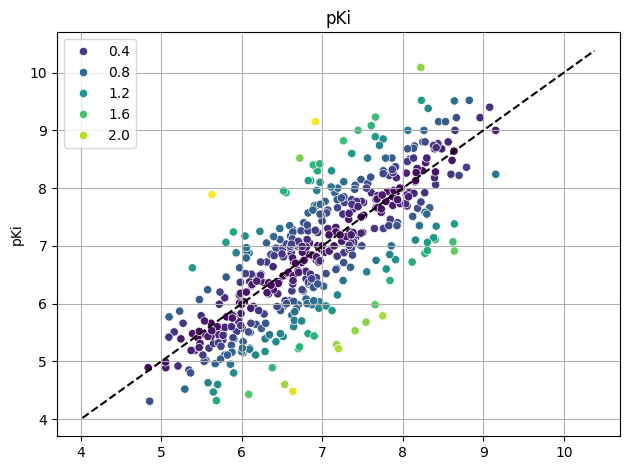

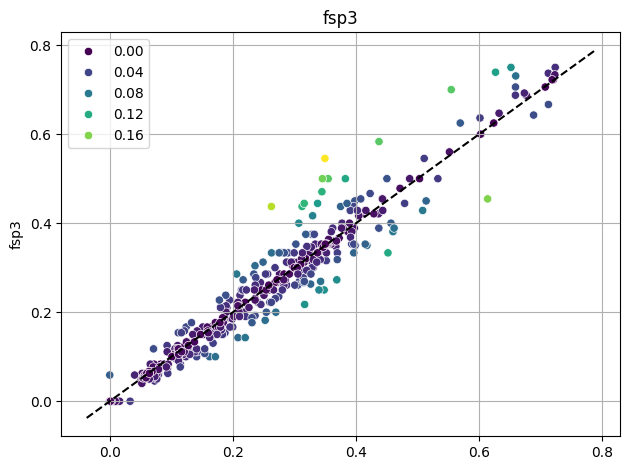

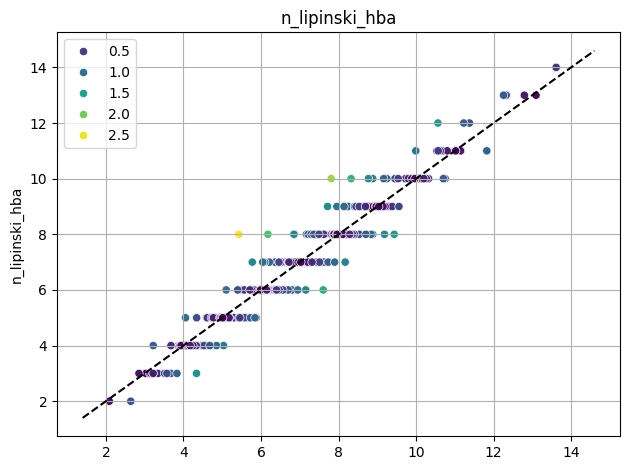

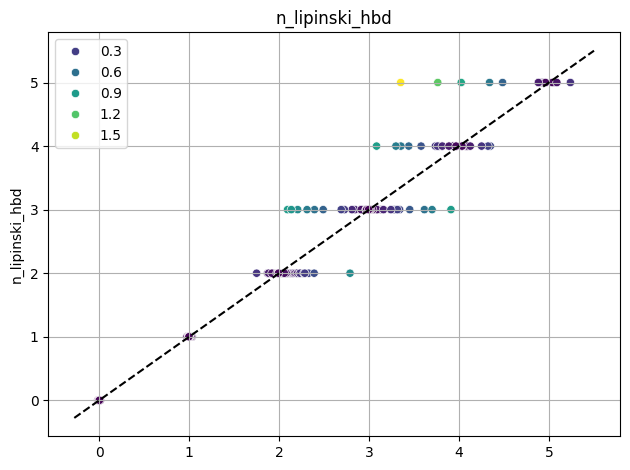

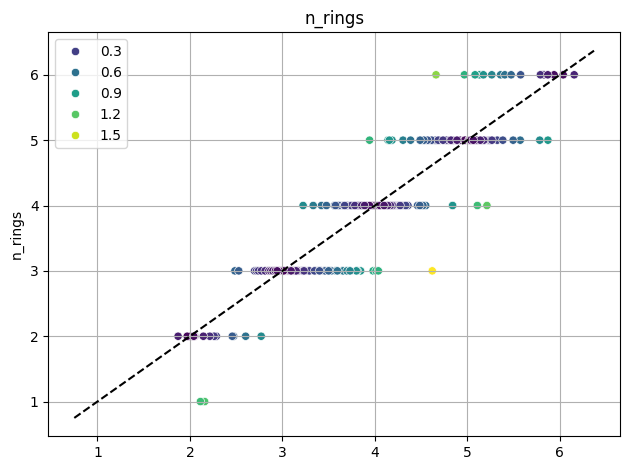

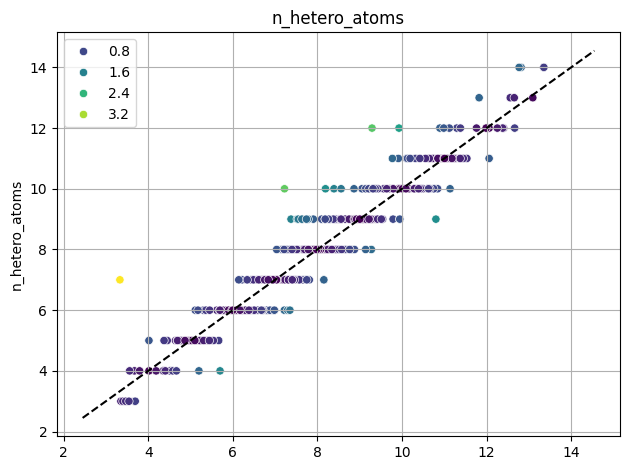

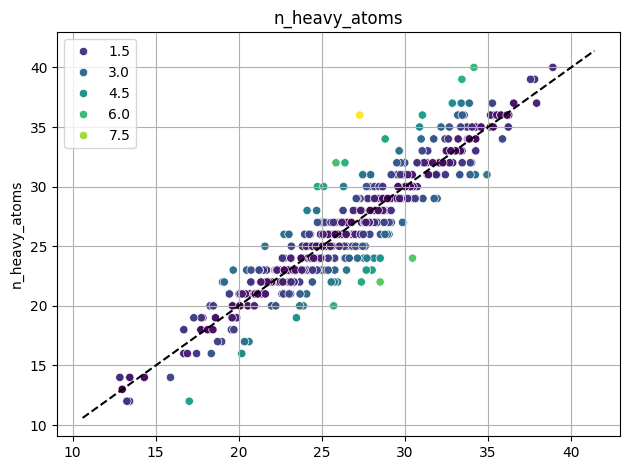

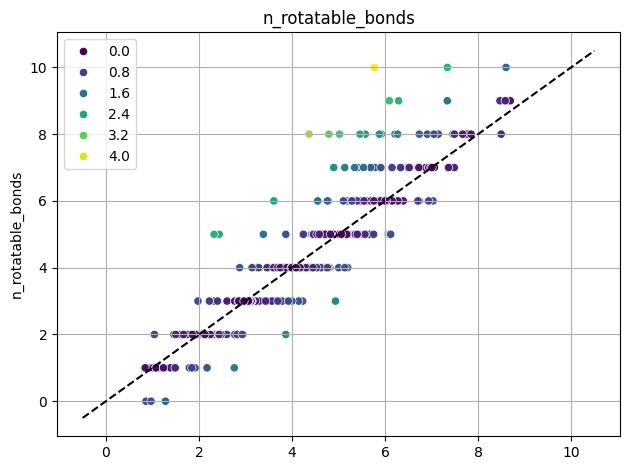

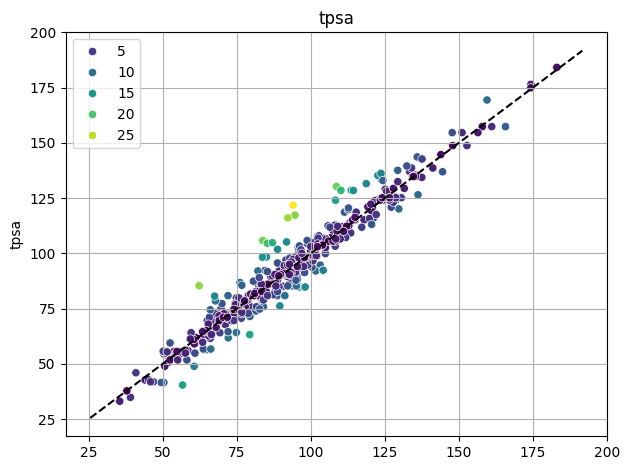

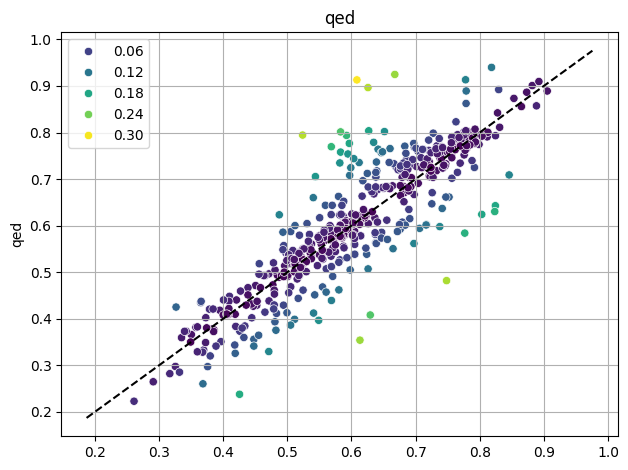

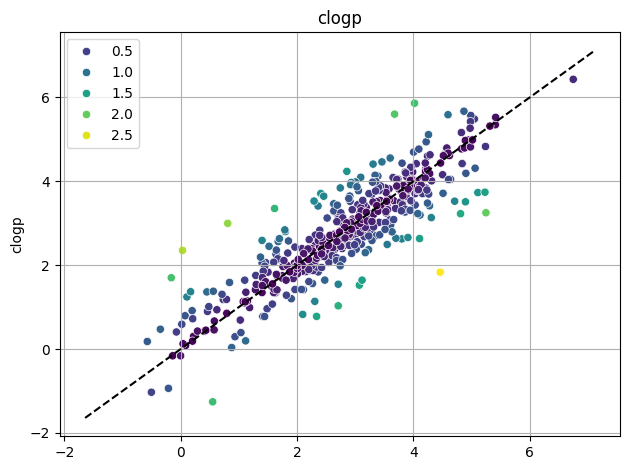

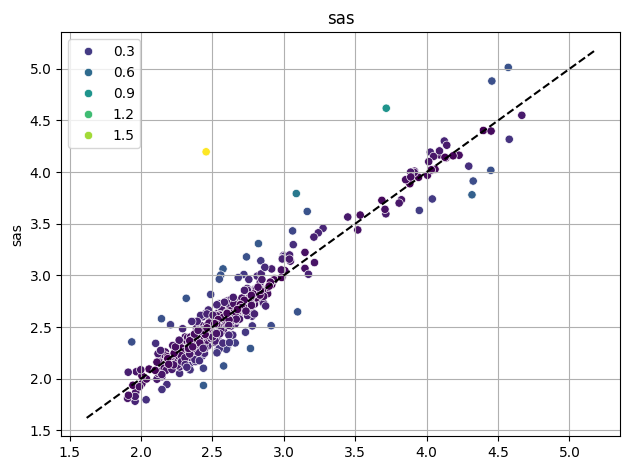

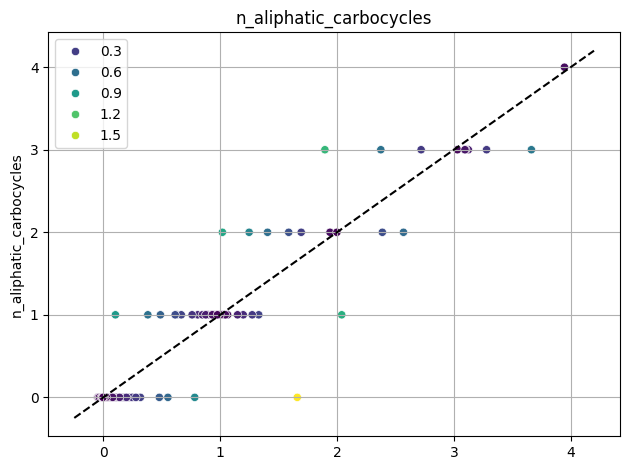

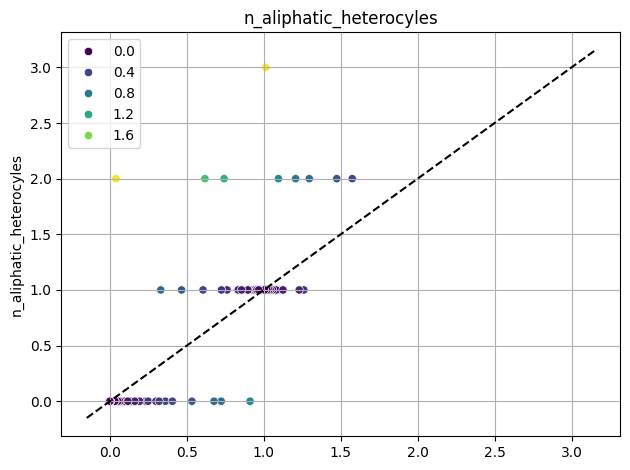

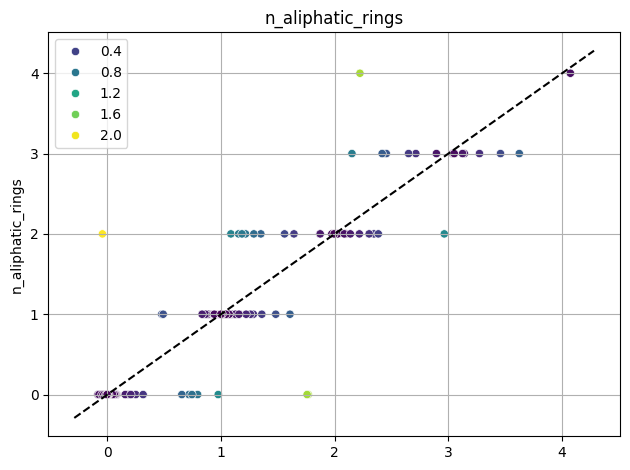

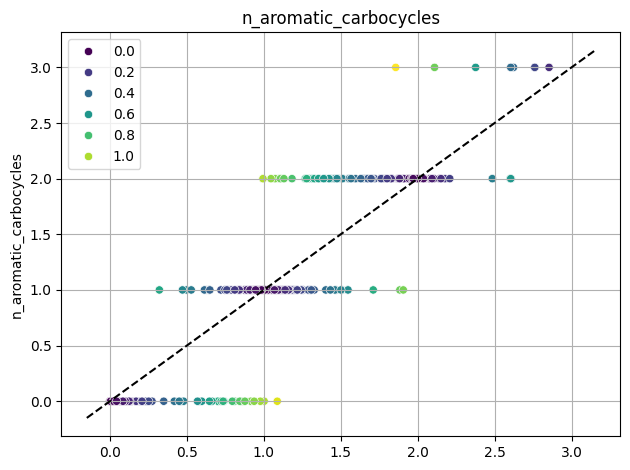

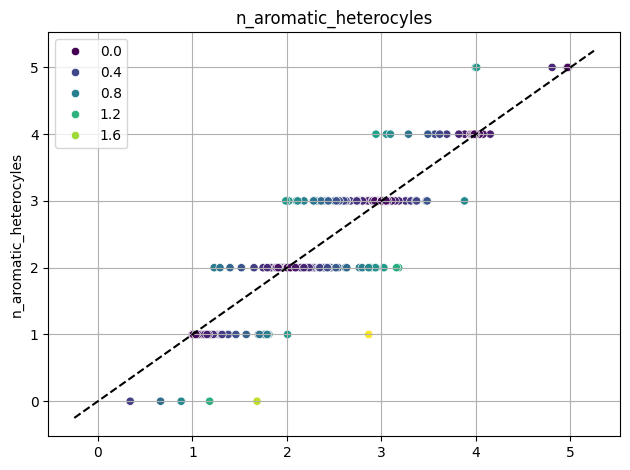

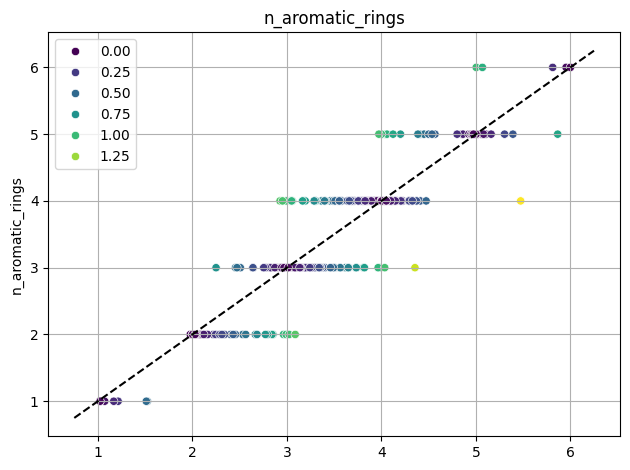

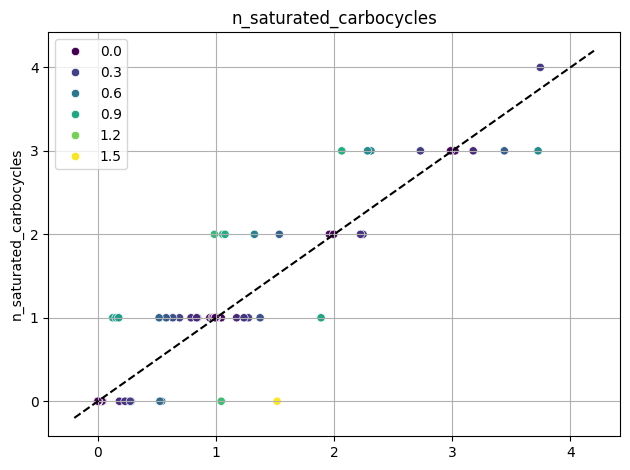

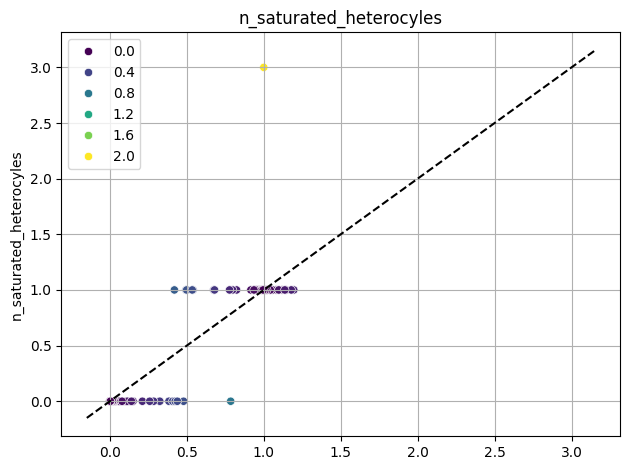

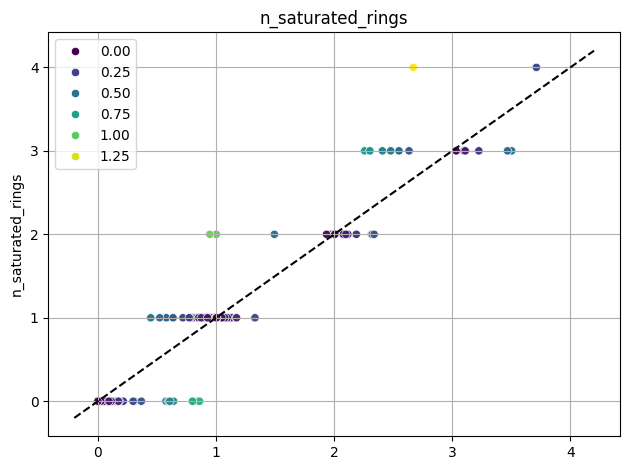

In [35]:
fig_num = 0
for name in desc_list:
    draw(name, fig_num)
    fig_num += 1